In [2]:
import sys
import numpy as np
import pandas as pd
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import copy
from IPython.display import display
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult
from aif360.algorithms.preprocessing import DisparateImpactRemover
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

from aif360.datasets import AdultDataset

# Ensure reproducibility
np.random.seed(1)

# Append a path if needed
sys.path.append("../")


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


These are features with numerical or continuous values:
age
education-num
capital-gain
capital-loss
hours-per-week

The rest of the features are categorical and therefore not suitable for Disparate Impact Remover.

DIR applies linear transformations to adjust feature values in the dataset. It aims to reduce the dependence of other features on the sensitive attribute (e.g., sex) while preserving the relative order of the data within each group. These transformations work well with continuous numerical features but encounter challenges with categorical features.Categorical features are often represented as discrete classes or labels (e.g., "Male" and "Female" or encoded as 0 and 1).
Linear transformations, such as scaling or shifting values, cannot meaningfully modify these discrete categories because they don't represent a numerical continuum. A linear transformation might produce invalid or nonsensical values like "1.5" or "0.7".
Numerical features (e.g., age, income) can be scaled, shifted, or transformed continuously while maintaining their interpretation and validity. This aligns perfectly with DIR’s mathematical framework, which is designed for numerical data.

The whole dataset with all features.

In [2]:
ds = AdultDataset()
df = pd.DataFrame(ds.features, columns=ds.feature_names)
df

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,workclass=Federal-gov,workclass=Local-gov,workclass=Private,...,native-country=Portugal,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia
0,25.0,7.0,0.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,38.0,9.0,1.0,1.0,0.0,0.0,50.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,28.0,12.0,1.0,1.0,0.0,0.0,40.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,44.0,10.0,0.0,1.0,7688.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,34.0,6.0,1.0,1.0,0.0,0.0,30.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,27.0,12.0,1.0,0.0,0.0,0.0,38.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45218,40.0,9.0,1.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45219,58.0,9.0,1.0,0.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45220,22.0,9.0,1.0,1.0,0.0,0.0,20.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
UNpreprocessed_dataset =  AdultDataset(protected_attribute_names=['sex'], 
    privileged_classes=[['Male']], categorical_features=[],
    features_to_keep=['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']) 
train, val_test = UNpreprocessed_dataset.split([0.7], shuffle=True)
val, test = val_test.split([0.5], shuffle=True)

The dataset with only numerical features.

In [4]:
df = pd.DataFrame(UNpreprocessed_dataset.features, columns=UNpreprocessed_dataset.feature_names)
df

,age,education-num,sex,capital-gain,capital-loss,hours-per-week
0,25.0,7.0,1.0,0.0,0.0,40.0
1,38.0,9.0,1.0,0.0,0.0,50.0
2,28.0,12.0,1.0,0.0,0.0,40.0
3,44.0,10.0,1.0,7688.0,0.0,40.0
4,18.0,10.0,0.0,0.0,0.0,30.0
...,...,...,...,...,...,...
48837,27.0,12.0,0.0,0.0,0.0,38.0
48838,40.0,9.0,1.0,0.0,0.0,40.0
48839,58.0,9.0,0.0,0.0,0.0,40.0
48840,22.0,9.0,1.0,0.0,0.0,20.0


In [4]:
# Evaluate fairness metrics before applying bias mitigation
metric_train = BinaryLabelDatasetMetric(train, unprivileged_groups, privileged_groups)
print("Train Dataset (Before Transformation):")
print(f"  Statistical Parity Difference: {metric_train.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_train.disparate_impact():.4f}")

metric_test = BinaryLabelDatasetMetric(test, unprivileged_groups, privileged_groups)
print("\nTest Dataset (Before Transformation):")
print(f"  Statistical Parity Difference: {metric_test.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_test.disparate_impact():.4f}")

Train Dataset (Before Transformation):
  Statistical Parity Difference: -0.1902
  Disparate Impact: 0.3678

Test Dataset (Before Transformation):
  Statistical Parity Difference: -0.1910
  Disparate Impact: 0.3740


In [5]:
disp_impact_remover = disparate_impact_remover = DisparateImpactRemover(repair_level= 1.0, sensitive_attribute="sex")

# Fit and transform training data
train_transf = disp_impact_remover.fit_transform(train)

val_transf = disp_impact_remover.fit_transform(val) #transform is not supported for this class

test_transf = disp_impact_remover.fit_transform(test)


In [6]:
# Evaluate fairness metrics after applying LFR
metric_train_after = BinaryLabelDatasetMetric(train_transf, unprivileged_groups, privileged_groups)
print("\nTrain Dataset (After Transformation):")
print(f"  Statistical Parity Difference: {metric_train_after.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_train_after.disparate_impact():.4f}")

metric_test_after = BinaryLabelDatasetMetric(test_transf, unprivileged_groups, privileged_groups)
print("\nTest Dataset (After Transformation):")
print(f"  Statistical Parity Difference: {metric_test_after.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_test_after.disparate_impact():.4f}")



Train Dataset (After Transformation):
  Statistical Parity Difference: -0.1902
  Disparate Impact: 0.3678

Test Dataset (After Transformation):
  Statistical Parity Difference: -0.1910
  Disparate Impact: 0.3740


Go to the end to see the explanation as to why Statistical Parity Difference and Disparate Impact did not change.

In [7]:
# Standardize the features
scaler = StandardScaler()
train.features = scaler.fit_transform(train.features)
val.features = scaler.transform(val.features)
test.features = scaler.transform(test.features)


Train a classifier with original data

In [19]:
classifier = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=10, random_state=1)


In [20]:
# Train a classifier on original training data
classifier.fit(train.features, train.labels.ravel())

# Predict on validation set
val_scores = classifier.predict_proba(val.features)[:, 1] #only for the favorable class?

# Select best threshold for validation set
thresholds = np.arange(0.01, 1, 0.01)
val_balanced_accs = []

for threshold in thresholds:
    val_LR_predictions = (val_scores >= threshold).astype(int)

    val_with_LR_scores = copy.deepcopy(val)
    val_with_LR_scores.labels = val_LR_predictions.reshape(-1, 1)  # Update labels with predictions

    val_metric = ClassificationMetric(val, val_with_LR_scores,
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
    balanced_acc = (val_metric.true_positive_rate() + val_metric.true_negative_rate()) / 2
    disparate_impact = val_metric.disparate_impact()
    avg_odds_diff = val_metric.average_odds_difference()

    val_balanced_accs.append(balanced_acc)

best_index = np.argmax(val_balanced_accs)
best_threshold = thresholds[best_index]
best_balanced_acc = val_balanced_accs[best_index]

print(f"Best Threshold (validation): {best_threshold}")
print(f"Best Balanced Accuracy (validation): {best_balanced_acc}")

Best Threshold (validation): 0.25
Best Balanced Accuracy (validation): 0.7890393540419456


In [21]:

# Apply the best threshold to the test set
test_scores = classifier.predict_proba(test.features)[:, 1]
test_LR_predictions= (test_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_with_LR_scores = copy.deepcopy(test)
test_with_LR_scores.labels = test_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_metric = ClassificationMetric(test, test_with_LR_scores,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

# Balanced Accuracy
true_positive_rate = test_metric.true_positive_rate()
true_negative_rate = test_metric.true_negative_rate()
balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy (test): {balanced_accuracy}")

# Statistical Parity Difference
statistical_parity_difference = test_metric.statistical_parity_difference()
print(f"Statistical Parity Difference (test): {statistical_parity_difference}")

# Disparate Impact
disparate_impact = test_metric.disparate_impact()
print(f"Disparate Impact (test): {disparate_impact}")

# Average Odds Difference
average_odds_difference = test_metric.average_odds_difference()
print(f"Average Odds Difference (test): {average_odds_difference}")

# Equal Opportunity Difference
equal_opportunity_difference = test_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference (test): {equal_opportunity_difference}")

# Theil Index
theil_index = test_metric.theil_index()
print(f"Theil Index (test): {theil_index}")

Balanced Accuracy (test): 0.7799539380533662
Statistical Parity Difference (test): -0.3677847766552117
Disparate Impact (test): 0.2374328225642989
Average Odds Difference (test): -0.30862957483751774
Equal Opportunity Difference (test): -0.35989428928069905
Theil Index (test): 0.0993494846322103


In [22]:
# Plot Test Metrics Over Thresholds
test_balanced_accs = []
test_disp_impacts = []
test_avg_odds_diffs = []

for threshold in thresholds:
    test_predictions = (test_scores >= threshold).astype(int)
    test_with_scores = copy.deepcopy(test)
    test_with_scores.labels = test_predictions.reshape(-1, 1)

    test_metric = ClassificationMetric(test, test_with_scores, unprivileged_groups, privileged_groups)
    test_balanced_accs.append((test_metric.true_positive_rate() + test_metric.true_negative_rate()) / 2)
    test_disp_impacts.append(test_metric.disparate_impact())
    test_avg_odds_diffs.append(test_metric.average_odds_difference())

In [25]:
%matplotlib inline

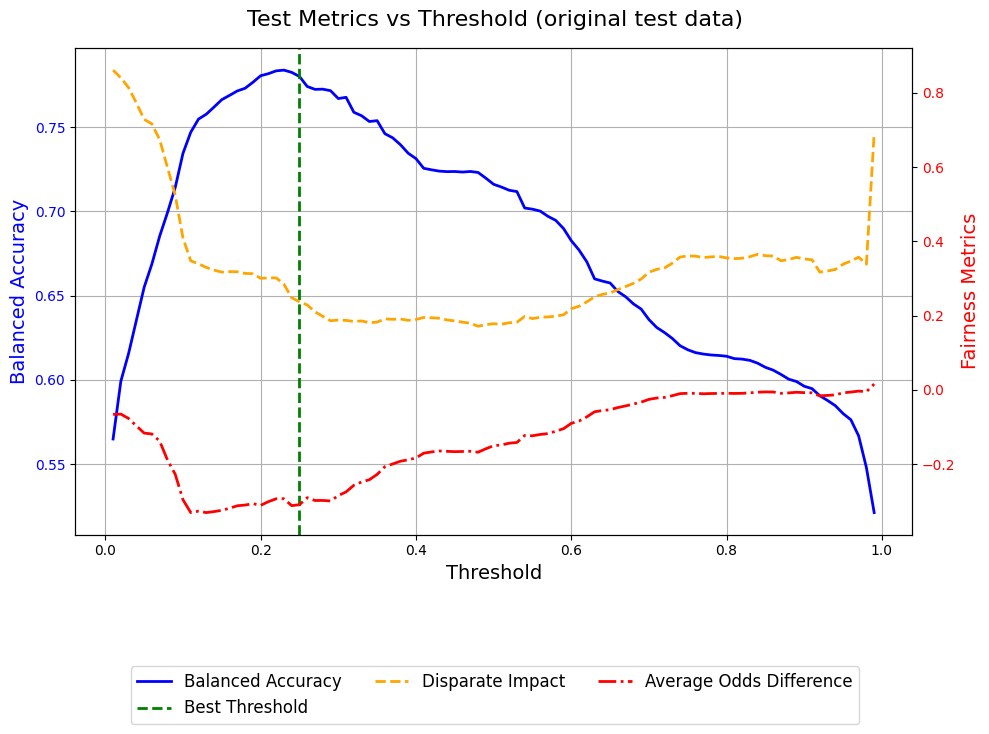

In [27]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (original test data)", fontsize=16)
fig.tight_layout()
plt.show()

Train a classifier on the transformed data

In [28]:
classifier = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=10, random_state=1)


In [29]:

indexOfSensitiveAttribute = train.feature_names.index("sex")
repair_levels = np.linspace(0., 1., 11) 

results = []
for repair_level in repair_levels:
    print(f"\n=== Repair Level: {repair_level} ===")
    
    # Apply Disparate Impact Remover with the current repair level
    disparate_impact_remover = DisparateImpactRemover(repair_level=repair_level, sensitive_attribute="sex")
    train_transf = disparate_impact_remover.fit_transform(train)
    test_transf = disparate_impact_remover.fit_transform(test)
    
    X_train = train_transf.features
    X_train_without_sensitive_attribute = np.delete(X_train, indexOfSensitiveAttribute, axis=1)
    y_train = train_transf.labels.ravel()

    # Train a classifier on transformed training data
    classifier.fit(X_train_without_sensitive_attribute, y_train)

    X_test_transf= test_transf.features
    X_test_transf_without_sensitive_attribute = np.delete(X_test_transf,
                                              indexOfSensitiveAttribute,
                                              axis=1)
    # Apply the best threshold to the transf test set
    test_transf_scores = classifier.predict_proba(X_test_transf_without_sensitive_attribute)[:, 1] #only for the favorable class?
    test_transf_LR_predictions= (test_transf_scores >= best_threshold).astype(int)

    # Create a copy of the test dataset and set predicted labels
    test_transf_with_LR_scores = copy.deepcopy(test)
    test_transf_with_LR_scores.labels = test_transf_LR_predictions.reshape(-1, 1)

    # Calculate fairness and performance metrics on the test set
    test_transf_metric = ClassificationMetric(test, test_transf_with_LR_scores,
                                    unprivileged_groups=unprivileged_groups,
                                    privileged_groups=privileged_groups)

        # Store results for current repair level

    true_positive_rate = test_transf_metric.true_positive_rate()
    true_negative_rate = test_transf_metric.true_negative_rate()
    balanced_accuracy_transf = (true_positive_rate + true_negative_rate) / 2
    statistical_parity_difference_transf = test_transf_metric.statistical_parity_difference()
    disparate_impact_transf = test_transf_metric.disparate_impact()
    average_odds_difference_transf = test_transf_metric.average_odds_difference()
    equal_opportunity_difference_transf = test_transf_metric.equal_opportunity_difference()
    theil_index_transf = test_transf_metric.theil_index()



    results.append({
        "Repair Level": repair_level,
        "Balanced Accuracy": balanced_accuracy_transf,
        "Statistical Parity Difference": statistical_parity_difference_transf,
        "Disparate Impact": disparate_impact_transf,
        "Average Odds Difference": average_odds_difference_transf,
        "Equal Opportunity Difference": equal_opportunity_difference_transf,
        "Theil Index": theil_index_transf
    })
    
# Display results for different repair levels
results_df = pd.DataFrame(results)
print("\nResults for Various Repair Levels:")
print(results_df)



=== Repair Level: 0.0 ===

=== Repair Level: 0.1 ===

=== Repair Level: 0.2 ===

=== Repair Level: 0.30000000000000004 ===

=== Repair Level: 0.4 ===

=== Repair Level: 0.5 ===

=== Repair Level: 0.6000000000000001 ===

=== Repair Level: 0.7000000000000001 ===

=== Repair Level: 0.8 ===

=== Repair Level: 0.9 ===

=== Repair Level: 1.0 ===

Results for Various Repair Levels:
    Repair Level  Balanced Accuracy  Statistical Parity Difference  \
0            0.0           0.759209                      -0.157961   
1            0.1           0.771829                      -0.229856   
2            0.2           0.771393                      -0.208950   
3            0.3           0.766907                      -0.205139   
4            0.4           0.762006                      -0.181419   
5            0.5           0.755514                      -0.152209   
6            0.6           0.758383                      -0.178223   
7            0.7           0.744353                      -0.1

The best result is with repair level = 0.7

In [34]:

indexOfSensitiveAttribute = train.feature_names.index("sex")
repair_level = 0.7 

results = []

print(f"\n=== Repair Level: {repair_level} ===")

# Apply Disparate Impact Remover with the current repair level
disparate_impact_remover = DisparateImpactRemover(repair_level=repair_level, sensitive_attribute="sex")
train_transf = disparate_impact_remover.fit_transform(train)
test_transf = disparate_impact_remover.fit_transform(test)

X_train = train_transf.features
X_train_without_sensitive_attribute = np.delete(X_train, indexOfSensitiveAttribute, axis=1)
y_train = train_transf.labels.ravel()

# Train a classifier on transformed training data
classifier.fit(X_train_without_sensitive_attribute, y_train)

X_test_transf= test_transf.features
X_test_transf_without_sensitive_attribute = np.delete(X_test_transf,
                                            indexOfSensitiveAttribute,
                                            axis=1)
# Apply the best threshold to the transf test set
test_transf_scores = classifier.predict_proba(X_test_transf_without_sensitive_attribute)[:, 1] #only for the favorable class?
test_transf_LR_predictions= (test_transf_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_transf_with_LR_scores = copy.deepcopy(test)
test_transf_with_LR_scores.labels = test_transf_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_transf_metric = ClassificationMetric(test, test_transf_with_LR_scores,
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)

    # Store results for current repair level

true_positive_rate = test_transf_metric.true_positive_rate()
true_negative_rate = test_transf_metric.true_negative_rate()
balanced_accuracy_transf = (true_positive_rate + true_negative_rate) / 2
statistical_parity_difference_transf = test_transf_metric.statistical_parity_difference()
disparate_impact_transf = test_transf_metric.disparate_impact()
average_odds_difference_transf = test_transf_metric.average_odds_difference()
equal_opportunity_difference_transf = test_transf_metric.equal_opportunity_difference()
theil_index_transf = test_transf_metric.theil_index()



results.append({
    "Repair Level": repair_level,
    "Balanced Accuracy": balanced_accuracy_transf,
    "Statistical Parity Difference": statistical_parity_difference_transf,
    "Disparate Impact": disparate_impact_transf,
    "Average Odds Difference": average_odds_difference_transf,
    "Equal Opportunity Difference": equal_opportunity_difference_transf,
    "Theil Index": theil_index_transf
})
    
# Display results for different repair levels
results_df = pd.DataFrame(results)
print("\nResults for Various Repair Levels:")
print(results_df)



=== Repair Level: 0.7 ===

Results for Various Repair Levels:
   Repair Level  Balanced Accuracy  Statistical Parity Difference  \
0           0.7           0.744353                      -0.110749   

   Disparate Impact  Average Odds Difference  Equal Opportunity Difference  \
0          0.671211                -0.018669                     -0.019328   

   Theil Index  
0     0.124386  


In [35]:
# Plot Test Metrics Over Thresholds
test_transf_balanced_accs = []
test_transf_disp_impacts = []
test_transf_avg_odds_diffs = []

for threshold in thresholds:
    test_transf_predictions = (test_transf_scores >= threshold).astype(int)
    test_transf_with_scores = copy.deepcopy(test)
    test_transf_with_scores.labels = test_transf_predictions.reshape(-1, 1)

    test_transf_metric = ClassificationMetric(test, test_transf_with_scores, unprivileged_groups, privileged_groups)
    test_transf_balanced_accs.append((test_transf_metric.true_positive_rate() + test_transf_metric.true_negative_rate()) / 2)
    test_transf_disp_impacts.append(test_transf_metric.disparate_impact())
    test_transf_avg_odds_diffs.append(test_transf_metric.average_odds_difference())

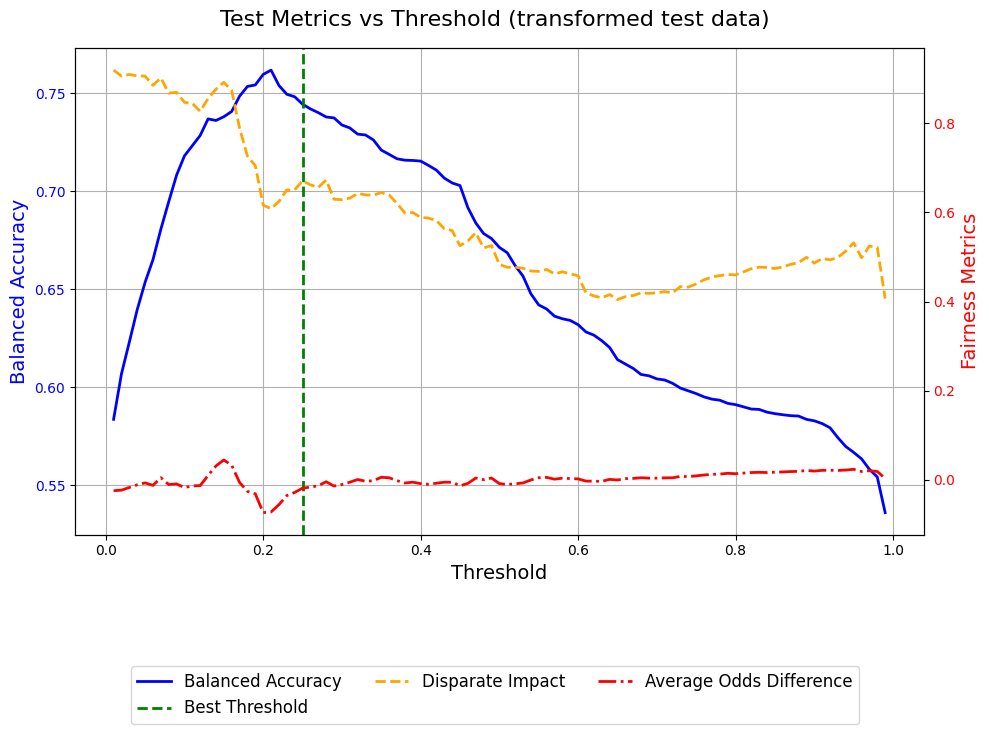

In [36]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_transf_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_transf_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_transf_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (transformed test data)", fontsize=16)
fig.tight_layout()
plt.show()

In [37]:
# Organizing the metrics with actual calculated values
results_data = {
    "Dataset": [
        "Train", "Train", "Test", "Test", 
        "Train", "Train", "Test", "Test", 
        "Validation", "Validation", 
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)"
    ],
    "Stage": [
        "Before Transformation", "After Transformation", 
        "Before Transformation", "After Transformation",
        "Before Transformation", "After Transformation", 
        "Before Transformation", "After Transformation",
        "Best Threshold (Validation)", "Best Threshold (Validation)",
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold"
    ],
    "Metric": [
        "Statistical Parity Difference", "Statistical Parity Difference",
        "Statistical Parity Difference", "Statistical Parity Difference",
        "Disparate Impact", "Disparate Impact",
        "Disparate Impact", "Disparate Impact",
        "Threshold", "Balanced Accuracy",
        "Balanced Accuracy", "Balanced Accuracy", 
        "Statistical Parity Difference", "Statistical Parity Difference", 
        "Disparate Impact", "Disparate Impact",
        "Average Odds Difference", "Average Odds Difference",
        "Equal Opportunity Difference", "Equal Opportunity Difference", 
        "Theil Index", "Theil Index"
    ],
    "Value": [
        metric_train.mean_difference(),
        metric_train_after.mean_difference(),
        metric_test.mean_difference(),
        metric_test_after.mean_difference(),
        metric_train.disparate_impact(),
        metric_train_after.disparate_impact(),
        metric_test.disparate_impact(),
        metric_test_after.disparate_impact(),
        best_threshold,
        best_balanced_acc,
        balanced_accuracy, balanced_accuracy_transf,
        statistical_parity_difference, statistical_parity_difference_transf,
        disparate_impact, disparate_impact_transf,
        average_odds_difference, average_odds_difference_transf,
        equal_opportunity_difference, equal_opportunity_difference_transf,
        theil_index, theil_index_transf
    ]
}

# Create the DataFrame
results_table = pd.DataFrame(results_data)

# Display the table
#display(results_table)


**Fairness Metrics Before and After Transformation**
- This table represents the fairness metrics (Statistical Parity Difference and Disparate Impact) for both the train and test datasets, before and after applying the transformation.

**Validation Metrics for Threshold Selection**
- This table contains metrics related to the validation phase, including the best threshold and corresponding balanced accuracy.

**Test Metrics After Applying Threshold**
- This table summarizes fairness and performance metrics calculated on the test set of the original and transformed dataset after applying the selected threshold.


In [38]:

# Separate the data into three groups
fairness_metrics = results_table.iloc[0:8].reset_index(drop=True)
validation_metrics = results_table.iloc[8:10].reset_index(drop=True)
test_metrics = results_table.iloc[10:22].reset_index(drop=True)

# Name the tables
fairness_metrics.name = "Fairness Metrics Before and After Transformation"
validation_metrics.name = "Validation Metrics for Threshold Selection"
test_metrics.name = "Test Metrics After Applying Threshold On Original and Transformed"

# Display the tables with their names
for table in [fairness_metrics, validation_metrics, test_metrics]:
    display(table.name)
    display(table)



'Fairness Metrics Before and After Transformation'

,Dataset,Stage,Metric,Value
0,Train,Before Transformation,Statistical Parity Difference,-0.190244
1,Train,After Transformation,Statistical Parity Difference,-0.190244
2,Test,Before Transformation,Statistical Parity Difference,-0.190984
3,Test,After Transformation,Statistical Parity Difference,-0.190984
4,Train,Before Transformation,Disparate Impact,0.367778
5,Train,After Transformation,Disparate Impact,0.367778
6,Test,Before Transformation,Disparate Impact,0.373983
7,Test,After Transformation,Disparate Impact,0.373983


'Validation Metrics for Threshold Selection'

,Dataset,Stage,Metric,Value
0,Validation,Best Threshold (Validation),Threshold,0.250000
1,Validation,Best Threshold (Validation),Balanced Accuracy,0.789039


'Test Metrics After Applying Threshold On Original and Transformed'

,Dataset,Stage,Metric,Value
0,Test (Original),After Threshold,Balanced Accuracy,0.779954
1,Test (Transformed),After Threshold,Balanced Accuracy,0.744353
2,Test (Original),After Threshold,Statistical Parity Difference,-0.367785
3,Test (Transformed),After Threshold,Statistical Parity Difference,-0.110749
4,Test (Original),After Threshold,Disparate Impact,0.237433
5,Test (Transformed),After Threshold,Disparate Impact,0.671211
6,Test (Original),After Threshold,Average Odds Difference,-0.308630
7,Test (Transformed),After Threshold,Average Odds Difference,-0.018669
8,Test (Original),After Threshold,Equal Opportunity Difference,-0.359894
9,Test (Transformed),After Threshold,Equal Opportunity Difference,-0.019328


Explanation:
-   Statistical Parity Difference and Disparate Impact are fairness metrics that evaluate the distribution of the **outcome labels** between privileged and unprivileged groups.
At the preprocessing stage (where we apply the Disparate Impact Remover), the labels (outcomes) of the dataset remain unchanged. The Disparate Impact Remover only modifies features, not the labels. Since the labels are not affected, these metrics do not change.

- In the final stage, after training the classifier, fairness metrics change significantly. This is because the predictions of the model are now based on the transformed features.The transformed features make the model less biased, leading to changes in the predicted outcomes, and thus, the fairness metrics improve.